# Noise injection into data

This example presents how the the noise can be injected into any part of the dataset: train, test and validation.
There are three types of noise implemented: 


- Gaussian
- Impulsive
- Shot



There are a few parameters which indicate how a given noise behaves:


- *pa* - Fraction of noisy pixels, the number of affected samples is calculated by: floor(n_samples * pa).
- *pb* - Fraction of noisy bands. When established the number of samples that undergo noise injection, for each sample the: floor(n_bands * pb) bands are affected.
- *bc* - Boolean indicating whether the indexes of affected bands, are constant for each sample. When set to: False, different bands can be augmented with noise for each pixel.
- *mean* - Gaussian noise parameter, the mean of the normal distribution.
- *std* - Gaussian noise parameter, standard deviation of the normal distribution.
- *pw* - Impulsive noise parameter, ratio of whitened pixels for the affected set of samples.


In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [ ]:
import os
import shutil
import re
from copy import copy

import clize
import mlflow
import tensorflow as tf
from clize.parameters import multi

from scripts import evaluate_model, prepare_data, train_model
from ml_intuition.data.utils import plot_training_curve, show_statistics

Specify path to the `.npy` dataset and ground truth, as well as the output path to store all the artifacts.

In [3]:
DEST_PATH = 'data_noise_injection_results'
DATA_FILE_PATH = os.path.join(os.path.dirname(os.getcwd()), 'datasets/pavia/pavia.npy')
GT_FILE_PAT = os.path.join(os.path.dirname(os.getcwd()), 'datasets/pavia/pavia_gt.npy')
experiment_dest_path = os.path.join(DEST_PATH, 'experiment_0')
os.makedirs(experiment_dest_path, exist_ok=True)

# Prepare the data

To fit into the the pipeline, the data has to be preprocessed. It is achieved by the `prepare_data.main` function. It accepts a path to a `.npy` file with the original cube as well as the corresponding ground truth.  In this example, we randomly extract 250 samples from each class (balanced scenario), use 10% of them as validation set, and extract only spectral information of a pixel. The returned object is a dictionary with three keys: `train`, `test` and `val`. Each of them contains an additional dictionary with `data` and `labels` keys, holding corresponding `numpy.ndarray` objects with the data. For more details about the parameters, refer to the documentation of `prepare_data.main` function (located in `scripts/prepare_data`).

In [4]:
data = prepare_data.main(data_file_path=DATA_FILE_PATH,
                            ground_truth_path=GT_FILE_PAT,
                            output_path=None,
                            train_size=250,
                            val_size=0.1,
                            stratified=True,
                            background_label=0,
                            channels_idx=2,
                            neighborhood_size=None,
                            save_data=False,
                            seed=0)

# Train the model with nosiy training set

The function `trian_model.train` executed the trainig procedure. In order to inject noise into the training set, provide `noise` with a name of the noise type, `noise_sets` with the set you would like to augment, and `noise_params` with the noise parameters. Trained model will be stored under `experiment_dest_path` folder path.

In [5]:
train_model.train(model_name='model_2d',
                    kernel_size=5,
                    n_kernels=200,
                    n_layers=1,
                    dest_path=experiment_dest_path,
                    data=data,
                    sample_size=103,
                    n_classes=9,
                    lr=0.001,
                    batch_size=128,
                    epochs=200,
                    verbose=0,
                    shuffle=True,
                    patience=15,
                    noise=['gaussian'],
                    noise_sets=['train'],
                    noise_params="{\"mean\": 0, \"std\": 1, \"pa\": 0.1, \"pb\": 1}")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 1, 200)        1200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 1, 200)        200200    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 1, 200)        200200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 1, 200)         200200    
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               200200    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25728     
__________

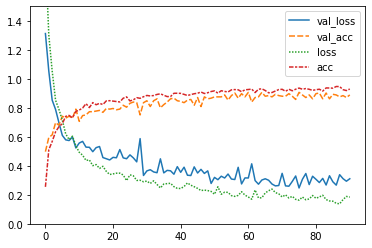

In [6]:
plot_training_curve(os.path.join(experiment_dest_path, "training_metrics.csv"), ['val_loss', 'val_acc', 'loss', 'acc'])

# Evaluate the model

Evaluate the model, calculating all metrics. All arfticats will be stored under provided `experiment_dest_path`. In this step, it is also possible to inject nosie into the `test` set, similarly to the previous function call. But first, let's evaluate the model on original test dataset:

In [ ]:
evaluate_model.evaluate(
    model_path=os.path.join(experiment_dest_path, 'model_2d'),
    data=copy(data),
    dest_path=experiment_dest_path,
    n_classes=9,
    batch_size=1024,
    noise=[],
    noise_sets=[])
tf.keras.backend.clear_session()

In [8]:
show_statistics(os.path.join(experiment_dest_path, "inference_metrics.csv"))

,accuracy_score,balanced_accuracy_score,cohen_kappa_score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,inference_time
0,0.859942,0.902939,0.816331,0.865068,0.827382,0.825311,0.955935,0.999087,0.862733,0.924074,0.868298,0.998565,6.757337


And now let's evaluate the model on the noisy test set, using Gaussian noise with mean 0 and std 1 affecting only 10% of the pixels

In [9]:
evaluate_model.evaluate(
    model_path=os.path.join(experiment_dest_path, 'model_2d'),
    data=copy(data),
    dest_path=os.path.join(experiment_dest_path, "noisy"),
    n_classes=9,
    batch_size=1024,
    noise=['gaussian'],
    noise_sets=['test'],
    noise_params="{\"mean\": 0, \"std\": 1, \"pa\": 0.1, \"pb\": 1}")

In [10]:
show_statistics(os.path.join(experiment_dest_path, "noisy", "inference_metrics.csv"))

,accuracy_score,balanced_accuracy_score,cohen_kappa_score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,inference_time
0,0.792183,0.836907,0.731185,0.790785,0.763085,0.763656,0.889126,0.968037,0.79117,0.844444,0.786422,0.935438,6.741781


We can see that the accuracy of the model droped in comparison with the original one.